In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

# Utility Functions

In [2]:
def make_mixed_classification(n_samples, n_features, n_categories):
    X,y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42, n_informative=5)
    cat_cols = random.choices(list(range(X.shape[-1])),k=n_categories)
    num_cols = [i for i in range(X.shape[-1]) if i not in cat_cols]
    for col in cat_cols:
        X[:,col] = pd.qcut(X[:,col], q=4).codes.astype(int)
    col_names = [] 
    num_col_names=[]
    cat_col_names=[]
    for i in range(X.shape[-1]):
        if i in cat_cols:
            col_names.append(f"cat_col_{i}")
            cat_col_names.append(f"cat_col_{i}")
        if i in num_cols:
            col_names.append(f"num_col_{i}")
            num_col_names.append(f"num_col_{i}")
    X = pd.DataFrame(X, columns=col_names)
    y = pd.Series(y, name="target")
    data = X.join(y)
    return data, cat_col_names, num_col_names

def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")

# Generate Synthetic Data 

First of all, let's create a synthetic data which is a mix of numerical and categorical features

In [3]:
data, cat_col_names, num_col_names = make_mixed_classification(n_samples=10000, n_features=20, n_categories=4)
train, test = train_test_split(data, random_state=42)
train, val = train_test_split(train, random_state=42)

# Importing the Library

In [4]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

## Define the Configs

This is the most crucial step in the process. There are four configs that you need to provide(most of them have intelligent default values), which will drive the rest of the process.

* DataConfig - Define the target column names, categorical and numerical column names, any transformation you need to do, etc.
* ModelConfig - There is a specific config for each of the models. This determines which model we are going to train and also lets you define the hyperparameters of the model
* TrainerConfig - This let's you configure the training process by setting things like batch_size, epochs, early stopping, etc. The vast majority of parameters are directly borrowed from PyTorch Lightning and is passed to the underlying Trainer object during training
* OptimizerConfig - This let's you define and use different Optimizers and LearningRate Schedulers. Standard PyTorch Optimizers and Learning RateSchedulers are supported. For custom optimizers, you can use the parameter in the fit method to overwrite this. The custom optimizer should be PyTorch compatible
* ExperimentConfig - This is an optional parameter. If set, this defines the Experiment Tracking. Right now, only two experiment tracking frameworks are supported: Tensorboard and Weights&Biases. W&B experiment tracker has more features like tracking the gradients and logits across epochs.

In [5]:
data_config = DataConfig(
    target=['target'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100,
    accelerator="auto", # can be 'cpu','gpu', 'tpu', or 'ipu' 
)
optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = GANDALFConfig(
    task="classification",
    gflu_stages=3, # Number of stages in the GFLU block
    gflu_dropout=0.0, # Dropout in each of the GFLU block
    gflu_feature_init_sparsity=0.1, # Sparsity of the initial feature selection
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

2023-12-08 14:52:18,002 - {pytorch_tabular.tabular_model:122} - INFO -          
Experiment Tracking is turned off                                               


## Training the Model 
Now that we have defined the configs and the TabularModel. We just need to call the `fit` method and pass the train and test dataframes. We can also pass in validation dataframe. But if omitted, TabularModel will separate 20%(also configurable) at random from the data as validation.

By default, EarlyStopping is enabled and is monitoring Validation Loss with a patience of 3 epochs. The trainer also saves the best model(based on validation loss) and loads that model at the end of training. `TrainerConfig` has the parameters to tweak this default behaviour.

In [6]:
tabular_model.fit(train=train, validation=val)

Seed set to 42


2023-12-08 14:52:22,972 - {pytorch_tabular.tabular_model:540} - INFO - Preparing
the DataLoaders                                                                 
2023-12-08 14:52:22,985 - {pytorch_tabular.tabular_datamodule:484} - INFO -     
Setting up the datamodule for classification task                               
2023-12-08 14:52:23,020 - {pytorch_tabular.tabular_model:589} - INFO - Preparing
the Model: GANDALFModel                                                         
2023-12-08 14:52:23,117 - {pytorch_tabular.tabular_model:307} - INFO - Preparing
the Trainer                                                                     


/home/manujosephv/pytorch_tabular/src/pytorch_tabular/models/base_model.py:157: UserWarning: Wandb is not installed. Please install wandb to log logits. You can install wandb using pip install wandb or install PyTorch Tabular using pip install pytorch-tabular[all]
  warnings.warn(
/home/manujosephv/pytorch_tabular/src/pytorch_tabular/models/base_model.py:164: UserWarning: Plotly is not installed. Please install plotly to log logits. You can install plotly using pip install plotly or install PyTorch Tabular using pip install pytorch-tabular[all]
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2023-12-08 14:52:23,381 - {pytorch_tabular.tabular_model:647} - INFO - Auto LR  
Find Started                                                                    


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/manujosephv/pytorch_tabular/docs/tutorials/lightning_logs
/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in t

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at /home/manujosephv/pytorch_tabular/docs/tutorials/.lr_find_b3a77c19-ea23-4417-88df-1a95b508168a.ckpt
Restored all states from the checkpoint at /home/manujosephv/pytorch_tabular/docs/tutorials/.lr_find_b3a77c19-ea23-4417-88df-1a95b508168a.ckpt


2023-12-08 14:52:27,574 - {pytorch_tabular.tabular_model:651} - INFO - Suggested
LR: 0.10964781961431852. For plot and detailed analysis, use                    
`find_learning_rate` method.                                                    
2023-12-08 14:52:27,575 - {pytorch_tabular.tabular_model:658} - INFO - Training 
Started                                                                         


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 14.5 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     92 │
│ 2 │ _head            │ Sequential       │     60 │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘
Trainable params: 14.6 K                                                        
Non-trainable params: 0                                                         
Total params: 14.6 K                                                            
Total estimated model params size (MB): 0                                       


Output()

2023-12-08 14:52:29,091 - {pytorch_tabular.tabular_model:660} - INFO - Training the model completed

2023-12-08 14:52:29,092 - {pytorch_tabular.tabular_model:1414} - INFO - Loading the best model

## Evaluating the Model

### Loss and Metrics on New Data
To evaluate the model on new data on the same metrics/loss that was used during training, we can use the `evaluate` method

In [7]:
result = tabular_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9296000003814697     │
│         test_loss         │    0.19221389293670654    │
└───────────────────────────┴───────────────────────────┘

/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


## Native Global Feature Importance

Some models like GANDALF, GATE, and FTTransformer have native feature importance, similar to the feature importance you get with GDBTs. 

In [9]:
tabular_model.feature_importance().sort_values("importance", ascending=False)

,Features,importance
4,num_col_1,1.000000e+00
16,num_col_15,1.000000e+00
3,cat_col_19,3.333333e-01
17,num_col_16,1.651433e-08
8,num_col_6,1.566230e-08
19,num_col_18,1.281001e-08
15,num_col_14,1.087461e-08
12,num_col_10,1.028104e-08
9,num_col_7,9.910396e-09
13,num_col_12,9.886777e-09


<Axes: >

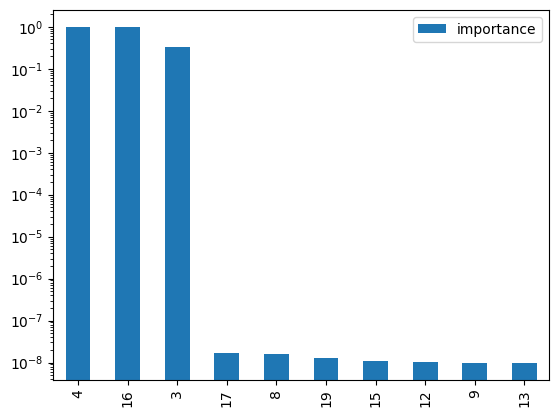

In [76]:
#bar plot, top 10 features
tabular_model.feature_importance().sort_values("importance", ascending=False).head(10).plot.bar(logy=True)

## Local Feature Attributions

We can also use techniques like SHAP to get local feature attributions. This is a very powerful technique to explain the predictions of the model. We can use the `explain` method to get the local feature attributions for a given input.

`PyTorch Tabular` supports these methods from `captum` for all models except Tabnet, TabTransformer, and MDN:


- GradientShap: https://captum.ai/api/gradient_shap.html
- IntegratedGradients: https://captum.ai/api/integrated_gradients.html
- DeepLift: https://captum.ai/api/deep_lift.html
- DeepLiftShap: https://captum.ai/api/deep_lift_shap.html
- InputXGradient: https://captum.ai/api/input_x_gradient.html
- FeaturePermutation: https://captum.ai/api/feature_permutation.html
- FeatureAblation: https://captum.ai/api/feature_ablation.html
- KernelShap: https://captum.ai/api/kernel_shap.html

`PyTorch Tabular` also supports explaining single instances as well as batches of instances. But, larger datasets will take longer to explain. An exception is the `FeaturePermutation` and `FeatureAblation` methods, which is only meaningful for large batches of instances.

Most of these explainability methods require a baseline. This is used to compare the attributions of the input with the attributions of the baseline. The baseline can be a scalar value, a tensor of the same shape as the input, or a special string like "b|100" which means 100 samples from the training data. If the baseline is not provided, the default baseline (zero) is used.

### Single Instance

In [58]:
exp = tabular_model.explain(test.head(1), method="GradientShap", baselines="b|10000")

In [59]:
exp = exp.T.sort_values(0, ascending=False)
exp.columns = ['GradientSHAP']
exp.index.name="Features"
exp.reset_index(inplace=True)
exp['colors'] = "red"
exp.loc[exp["GradientSHAP"]>0, "colors"] = "green"

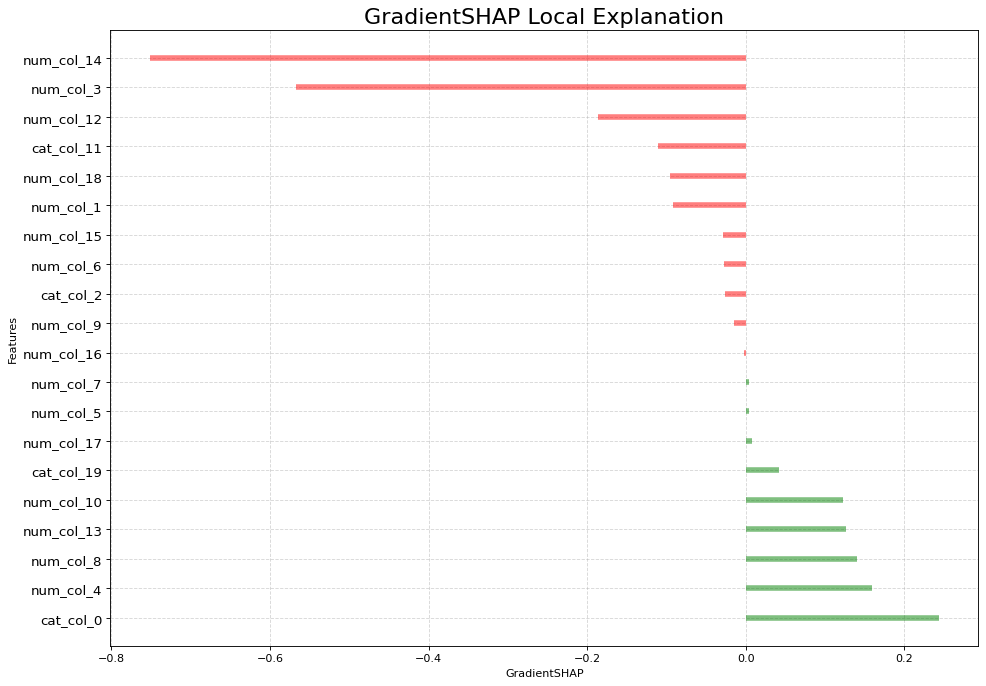

In [60]:

# Draw plot 
plt.figure(figsize=(14, 10), dpi=80) 
  
# Plotting the horizontal lines 
plt.hlines(y=exp.index, linewidth=5, xmin=0, xmax=exp.GradientSHAP, colors=exp.colors.values, alpha=0.5)
# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(ylabel='Features', xlabel='GradientSHAP') 
  
# Setting Date to y-axis 
plt.yticks(exp.index, exp.Features, fontsize=12) 
  
# Title of Bar Chart 
plt.title('GradientSHAP Local Explanation', fontdict={ 
          'size': 20}) 
  
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
  
# Displaying the Diverging Bar Chart 
plt.show() 

### Multiple Instances

In [61]:
exp = tabular_model.explain(test[test.cat_col_19==3], method="GradientShap", baselines="b|10000")

In [77]:
exp.head()

,num_col_1,num_col_3,num_col_4,num_col_5,num_col_6,num_col_7,num_col_8,num_col_9,num_col_10,num_col_12,num_col_13,num_col_14,num_col_15,num_col_16,num_col_17,num_col_18,cat_col_0,cat_col_2,cat_col_11,cat_col_19
0,0.181638,0.391463,-0.288542,0.866874,0.069802,0.002030,0.359382,-0.158450,-0.042014,0.134169,0.110338,-0.073405,0.019971,0.055664,0.048078,-0.069901,-0.233139,0.149520,-0.088944,-0.172214
1,0.850393,0.998055,0.028590,0.057088,0.020867,-0.003221,0.002015,-0.576683,0.155946,-0.493926,0.115358,-0.347492,-0.064912,-0.118276,0.319102,0.017092,1.515452,0.142387,0.042492,-0.027000
2,-0.456903,0.548388,-0.051724,1.529312,-0.005730,-0.006423,-0.058475,0.025674,0.363776,-0.259362,0.012468,-0.342987,0.039702,-0.105502,0.080233,-0.066426,-0.175915,0.058416,0.039881,-0.167353
3,-0.120079,0.401902,-0.011365,1.458246,-0.046081,-0.001651,0.017665,1.020984,0.502747,-1.010814,-0.245685,1.061822,0.112867,0.070102,0.430361,-0.281425,-0.079304,-0.426460,-0.298247,0.408934
4,3.442730,1.517699,0.003402,-5.255832,-0.049715,0.014016,-0.028709,0.446060,0.028204,0.316919,0.861432,1.093038,-0.015613,0.150772,-0.075140,-0.550907,-2.511157,1.605713,-0.424531,-0.104891


In [74]:
exp_agg = exp.abs().sum().to_frame()
exp_agg = exp_agg.sort_values(0, ascending=True)
exp_agg.columns = ['GradientSHAP']
exp_agg.index.name="Features"
exp_agg.reset_index(inplace=True)
exp_agg['colors'] = "red"
exp_agg.loc[exp_agg["GradientSHAP"]>0, "colors"] = "green"

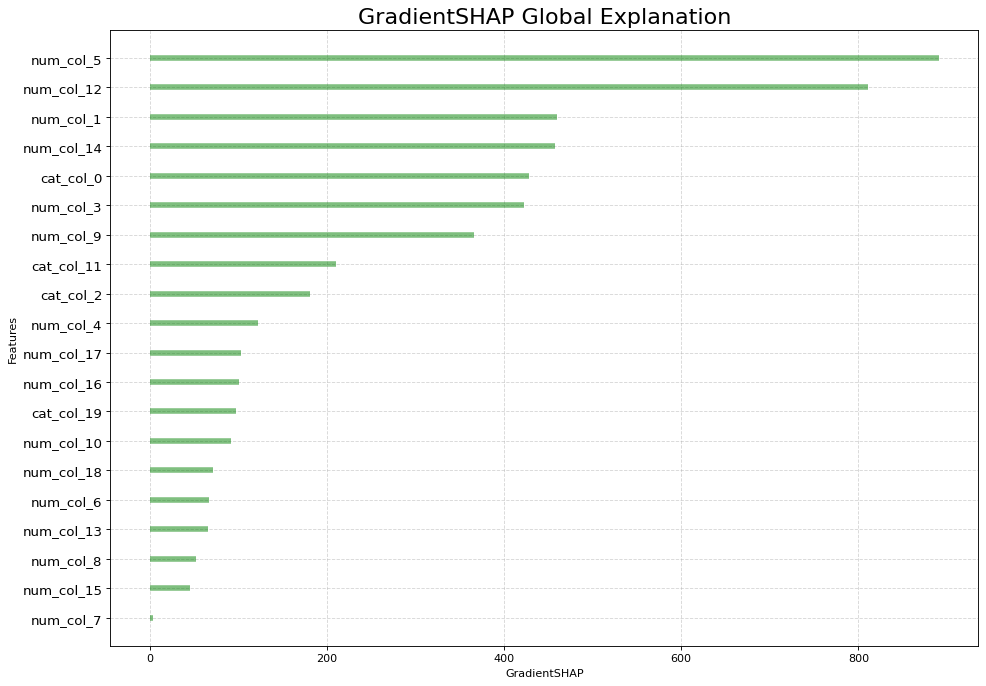

In [75]:

# Draw plot 
plt.figure(figsize=(14, 10), dpi=80) 
  
# Plotting the horizontal lines 
plt.hlines(y=exp_agg.index, linewidth=5, xmin=0, xmax=exp_agg.GradientSHAP, colors=exp_agg.colors.values, alpha=0.5)
# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(ylabel='Features', xlabel='GradientSHAP') 
  
# Setting Date to y-axis 
plt.yticks(exp_agg.index, exp_agg.Features, fontsize=12) 
  
# Title of Bar Chart 
plt.title('GradientSHAP Global Explanation', fontdict={ 
          'size': 20}) 
  
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
  
# Displaying the Diverging Bar Chart 
plt.show() 